# AML Package for Text Analytics - Text Classification

In this notebook, you can learn how to train and deploy a text classification model with **Azure Machine Learning Package for Text Analytics** (AMLPTA). The goal of text classification is to assign a piece of text to one or more predefined classes or categories. This text could, for example, be a document, news article, search query, email, tweet, support tickets.

There are broad applications of text classification such as: 
+ Categorizing newspaper articles and news wire contents into topics
+ Organizing web pages into hierarchical categories 
+ Filtering spam email
+ Sentiment analysis
+ Predicting user intent from search queries
+ Routing support tickets
+ Analyzing customer feedback 

The text classification model building and deployment workflow for a model with AMLPTA is as follows:

1. Load the data
2. Train the model
3. Apply the classifier 
4. Evaluate model performance
5. Save the pipeline
6. Test the pipeline
8. Deploy the model as a web service

Consult the [package reference documentation](https://aka.ms/aml-packages/text) for the detailed reference for each module and class.

The sample code in this notebook uses a scikit-learn pipeline.

## Prerequisites 

1. If you don't have an Azure subscription, create a [free account](https://azure.microsoft.com/free/?WT.mc_id=A261C142F) before you begin.

1. The following accounts and application must be set up and installed:
   - Azure Machine Learning Experimentation account 
   - An Azure Machine Learning Model Management account
   - Azure Machine Learning Workbench installed

   If these three are not yet created or installed, follow the [Azure Machine Learning Quickstart and Workbench installation](../service/quickstart-installation.md) article. 

1. The Azure Machine Learning Package for Text Analytics must be installed. Learn how to [install this package here](https://aka.ms/aml-packages/text).


## Sample data and Jupyter notebook

### Download and Explore the sample data
The following example uses the [20 newsgroups dataset](http://qwone.com/~jason/20Newsgroups/)  that is available through the scikit-learn library to demonstrate how to create a text classifier with Azure Machine Learning Package for Text Analytics. 

The 20 newsgroups dataset has around 18,000 newsgroups posts on 20 different topics divided into two subsets: one for training and the other one for performance evaluation. The split into train and test is based upon each message post date whether before or after a specific date.

In [1]:
# Import Packages 
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
#%azureml history on
%matplotlib inline
# Use the Azure Machine Learning data collector to log various metrics
from azureml.logging import get_azureml_logger
import os
import warnings
logger = get_azureml_logger()

# Log cell runs into run history
logger.log('Cell','Set up run')

warnings.filterwarnings("ignore")

---
Metadata-Version: 2.0
Name: azureml-tatk
Version: 0.1.18121.30a1
Summary: Microsoft Azure Machine Learning Package for Text Analytics
Home-page: https://microsoft.sharepoint.com/teams/TextAnalyticsPackagePreview
Author: Microsoft Corporation
Author-email: amltap@microsoft.com
Installer: pip
License: UNKNOWN
Location: c:\users\tatk\appdata\local\amlworkbench\python\lib\site-packages
Requires: ruamel.yaml, dill, gensim, sklearn-crfsuite, bqplot, h5py, pdfminer.six, azure-storage, pytest, ipywidgets, lxml, qgrid, keras, requests, docker, matplotlib, ipython, pandas, nltk, pyspark, scikit-learn, scipy, jsonpickle, numpy, nose, azure-ml-api-sdk, validators, unidecode
Classifiers:


You are using pip version 8.1.2, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


0

### Set the location of the data
Set the location where you have downloaded the data and load them into pandas dataframes.
You can also use your own data where the input data file is *.tsv format.


In [2]:
import os
import pandas as pd

#set the working directory where to save the training data files
resources_dir = os.path.join(os.path.expanduser("~"), "tatk", "resources")
data_dir = os.path.join(os.path.expanduser("~"), "tatk", "data")

from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(data_home=data_dir, subset='train')
X_train, y_train = twenty_train.data, twenty_train.target
df_train = pd.DataFrame({"text":X_train, "label":y_train})

twenty_test = fetch_20newsgroups(data_home=data_dir, subset='test')
X_test, y_test = twenty_test.data, twenty_test.target   
df_test = pd.DataFrame({"text":X_test, "label":y_test})

# Training Dataset Location
#training_file_path = <specify-your-own-training-data-file-path-here>
# df_train = pd.read_csv(training_file_path,
#                        sep = '\t',                        
#                        header = 0, names= <specify-your-column-name-list-here>)
df_train.head()
print("df_train.shape= {}".format(df_train.shape))

# Test Dataset Location
#test_file_path = <specify-your-own-test-data-file-path-here>
# df_test = pd.read_csv(test_file_path,
#                       sep = '\t',                        
#                       header = 0, names= <specify-your-column-name-list-here>)

print("df_test.shape= {}".format(df_test.shape))
df_test.head()

df_train.shape= (11314, 2)
df_test.shape= (7532, 2)


,label,text
0,7,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...
1,5,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...
2,0,From: mathew <mathew@mantis.co.uk>\nSubject: R...
3,17,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...
4,19,From: livesey@solntze.wpd.sgi.com (Jon Livesey...


Get the correspondance between categories and their name.

In [3]:
int_to_categories = pd.DataFrame({'category':range(20), 'category_name': list(twenty_train.target_names)})
int_to_categories 

,category,category_name
0,0,alt.atheism
1,1,comp.graphics
2,2,comp.os.ms-windows.misc
3,3,comp.sys.ibm.pc.hardware
4,4,comp.sys.mac.hardware
5,5,comp.windows.x
6,6,misc.forsale
7,7,rec.autos
8,8,rec.motorcycles
9,9,rec.sport.baseball



Now, you can create a preliminary exploration plot histogram of the class frequency in training and test data sets.

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


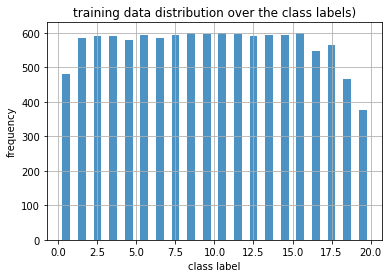

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


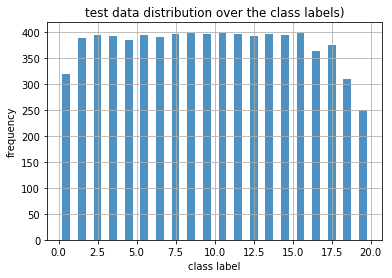

In [4]:
import numpy as np
import math
from matplotlib import pyplot as plt

data = df_train["label"].values
labels = set(data)
print(labels)
bins = range(len(labels)+1) 

plt.hist(data, bins=bins, alpha=0.8, rwidth=0.5)
plt.title('training data distribution over the class labels)')
plt.xlabel('class label')
plt.ylabel('frequency')
plt.grid(True)
plt.show()

data = df_test["label"].values
labels = set(data)
print(labels)
bins = range(len(labels)+1) 


plt.hist(data, bins=bins, alpha=0.8, rwidth=0.5)
plt.title('test data distribution over the class labels)')
plt.xlabel('class label')
plt.ylabel('frequency')
plt.grid(True)
plt.show()

## Train the model

### Specify scikit-learn algorithm and define the text classifier

This step involves training a scikit-learn text classification model using One-versus-Rest LogisticRegression learning algorithm.

For the full list of learnings, refer to the [Scikit Learners](http://scikit-learn.org/stable/supervised_learning) documentation.

In [5]:
from sklearn.linear_model import LogisticRegression
import tatk
from tatk.pipelines.text_classification.text_classifier import TextClassifier

# Define the scikit-learn estimator.
log_reg_learner = LogisticRegression(penalty='l2', dual=False,
                                     tol=0.0001, C=1.0, fit_intercept=True,
                                     intercept_scaling=1, class_weight=None,
                                     random_state=None, solver='lbfgs', 
                                     max_iter=100, multi_class='ovr',
                                     verbose=1, warm_start=False, n_jobs=3) 

# Define the text classifier model.
# It will fit the learner on the text column "text".
text_classifier = TextClassifier(estimator=log_reg_learner, 
                                 text_cols = ["text"], 
                                 label_cols = ["label"], 
#                                numeric_cols = None,
#                                cat_cols = None, 
                                 extract_word_ngrams=True,
                                 extract_char_ngrams=True)


'pattern' package not found; tag filters are not available for English
TextClassifier::create_pipeline ==> start
:: number of jobs for the pipeline : 6
0	text_nltk_preprocessor
1	text_word_ngrams
2	text_char_ngrams
3	assembler
4	learner
TextClassifier::create_pipeline ==> end


### Fit the model

Use the default parameters of the package. By default, the text classifier extracts:
+ Word unigrams and bigrams
+ Character 4 grams


In [6]:
text_classifier.fit(df_train)        

TextClassifier::fit ==> start
schema: col=label:I4:0 col=text:TX:1 header+
NltkPreprocessor::tatk_fit_transform ==> start
NltkPreprocessor::tatk_fit_transform ==> end 	 Time taken: 0.08 mins
NGramsVectorizer::tatk_fit_transform ==> startNGramsVectorizer::tatk_fit_transform ==> start

			vocabulary size=216393
NGramsVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.39 mins
			vocabulary size=67230
NGramsVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.49 mins
VectorAssembler::transform ==> start, num of input records=11314
(11314, 216393)
(11314, 67230)
all_features::
(11314, 283623)
Time taken: 0.06 mins
VectorAssembler::transform ==> end
LogisticRegression::tatk_fit ==> start


[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  2.3min finished


LogisticRegression::tatk_fit ==> end 	 Time taken: 2.31 mins
Time taken: 2.94 mins
TextClassifier::fit ==> end


TextClassifier(add_index_col=False, callable_proprocessors_list=None,
        cat_cols=None, char_hashing_original=False, col_prefix='tmp_00_',
        decompose_n_grams=False, detect_phrases=False,
        dictionary_categories=None, dictionary_file_path=None,
        embedding_file_path=None, embedding_file_path_fastText=None,
        estimator=None, estimator_vectorizers_list=None,
        extract_char_ngrams=True, extract_word_ngrams=True,
        label_cols=['label'], numeric_cols=None,
        pos_tagger_vectorizer=False,
        preprocessor_dictionary_file_path=None, regex_replcaement='',
        replace_regex_pattern=None, scale_numeric_cols=False,
        text_callable_list=None, text_cols=['text'], text_regex_list=None,
        weight_col=None)

### Examine and set the parameters of the different pipeline steps

Although the fitting of a scikit-learn model, preprocessing is being done prior to fitting using a pipeline of preprocessor and featurizer (transformation) steps. Hence, the reference to a "pipeline" for training. During evaluation, the full pipeline, including preprocessing and scikit-learn model prediction, is applied to a testing data set.

***Example shown with text_word_ngrams*** 

Typically, you set the parameters before you fit a model. 

The following code samples show you how to train the model using the default pipeline and model parameters. 

To see what parameters are included for "text_word_ngrams", use [get_step_param_names_by_name](https://docs.microsoft.com/python/api/tatk.core.base_text_model.basetextmodel). This function returns the parameters such as lowercase, input_col, output_col and so on. 

In [7]:
text_classifier.get_step_param_names_by_name("text_word_ngrams")

['stop_words',
 'decode_error',
 'vocabulary',
 'analyzer',
 'binary',
 'strip_accents',
 'output_col',
 'preprocessor',
 'encoding',
 'ngram_range',
 'max_features',
 'smooth_idf',
 'token_pattern',
 'norm',
 'hashing',
 'input',
 'max_df',
 'n_hashing_features',
 'input_col',
 'tokenizer',
 'min_df',
 'use_idf',
 'save_overwrite',
 'dtype',
 'sublinear_tf',
 'lowercase']

Next, check the parameter values for "text_char_ngrams":

In [8]:
text_classifier.get_step_params_by_name("text_word_ngrams")        

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float32,
 'encoding': 'utf-8',
 'hashing': False,
 'input': 'content',
 'input_col': 'NltkPreprocessordc6ce15b10c0475e895776bc270cdb85',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 3,
 'n_hashing_features': None,
 'ngram_range': (1, 2),
 'norm': 'l2',
 'output_col': 'NGramsVectorizer2c3b32edede4490daaa1219265ac97f0',
 'preprocessor': None,
 'save_overwrite': True,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

If necessary, you can change the default parameters.  With the following code, you can change the range of extracted character n-grams from (4,4) to (3,4) to extract both character tri-grams and 4 grams:

In [9]:
text_classifier.set_step_params_by_name("text_char_ngrams", ngram_range =(3,4)) 
text_classifier.get_step_params_by_name("text_char_ngrams")

{'analyzer': 'char_wb',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float32,
 'encoding': 'utf-8',
 'hashing': False,
 'input': 'content',
 'input_col': 'NltkPreprocessordc6ce15b10c0475e895776bc270cdb85',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 3,
 'n_hashing_features': None,
 'ngram_range': (3, 4),
 'norm': 'l2',
 'output_col': 'NGramsVectorizer0e911e061bba4e859976a1403db4f637',
 'preprocessor': None,
 'save_overwrite': True,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

### Export the parameters to a file
If needed, you can optimize model performance by rerunning the model fitting step with revised parameters:

In [10]:
import os
params_file_path = os.path.join(resources_dir, "params.tsv")
text_classifier.export_params(params_file_path)
print("Saving the configuration parameters to {}".format(params_file_path))

Saving the configuration parameters to C:\Users\tatk\tatk\resources\params.tsv


## Apply the classifier

Apply the trained text classifier on the test dataset to generate class predictions:


In [11]:
df_test = text_classifier.predict(df_test)
df_test.head()

TextClassifier ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.05 mins
NGramsVectorizer::tatk_transform ==> startNGramsVectorizer::tatk_transform ==> start

NGramsVectorizer::tatk_transform ==> end 	 Time taken: 0.14 mins
NGramsVectorizer::tatk_transform ==> end 	 Time taken: 0.35 mins
VectorAssembler::transform ==> start, num of input records=7532
(7532, 216393)
(7532, 67230)
all_features::
(7532, 283623)
Time taken: 0.03 mins
VectorAssembler::transform ==> end
LogisticRegression::tatk_predict_proba ==> start
LogisticRegression::tatk_predict_proba ==> end 	 Time taken: 0.0 mins
LogisticRegression::tatk_predict ==> start
LogisticRegression::tatk_predict ==> end 	 Time taken: 0.0 mins
Time taken: 0.44 mins
TextClassifier ::predict ==> end
Order of Labels in predicted probabilities saved to attribute label_order of the class object


,label,text,probabilities,prediction
0,7,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,"[0.0165036341329, 0.0548664746457, 0.020549685...",12
1,5,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,"[0.0251454989949, 0.125877400021, 0.0394704787...",1
2,0,From: mathew <mathew@mantis.co.uk>\nSubject: R...,"[0.67566338235, 0.0150749738583, 0.00992439163...",0
3,17,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,"[0.146063943868, 0.00232465192179, 0.002442807...",18
4,19,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,"[0.670712265296, 0.0173322697029, 0.0106242966...",0


## Evaluate model performance
The [evaluation module](https://docs.microsoft.com/python/api/tatk.evaluation) evaluates the accuracy of the trained text classifier on the test dataset. The evaluate function generates a confusion matrix and provides a macro-F1 score.

In [12]:
 evaluator = text_classifier.evaluate(df_test)          

TextClassifier ::evaluate ==> start
Time taken: 0.0 mins
TextClassifier ::evaluate ==> end


Plot the confusion without normalization matrix for visualization.

Confusion matrix, without normalization


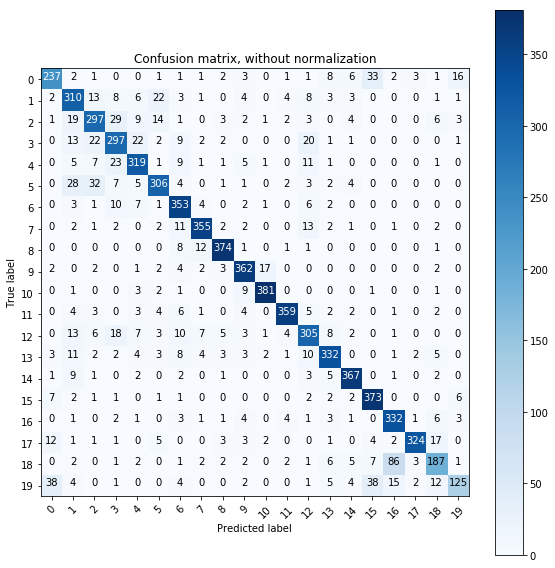

In [13]:
evaluator.plot_confusion_matrix(normalize=False,
                                title='Confusion matrix, without normalization', 
                                print_confusion_matrix=False,
                                figsize=(8,8),
                                colors=None)

Plot the normalized confusion matrix for visualization.

Normalized confusion matrix


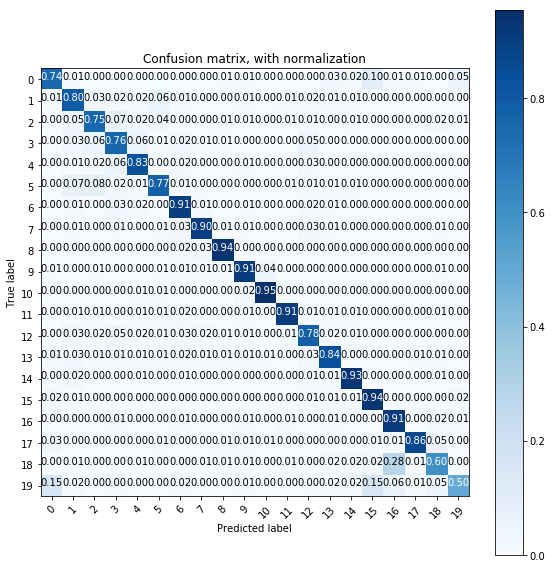

In [14]:
evaluator.plot_confusion_matrix(normalize=True,
                                title='Confusion matrix, with normalization', 
                                print_confusion_matrix=False,
                                figsize=(8,8),
                                colors=None)

In [15]:
evaluator.get_metrics('precision')

{0: 0.7821782178217822,
 1: 0.7209302325581395,
 2: 0.7615384615384615,
 3: 0.7388059701492538,
 4: 0.8158567774936062,
 5: 0.8292682926829268,
 6: 0.8041002277904328,
 7: 0.9033078880407125,
 8: 0.9280397022332506,
 9: 0.8786407766990292,
 10: 0.9384236453201971,
 11: 0.9447368421052632,
 12: 0.7741116751269036,
 13: 0.8668407310704961,
 14: 0.9129353233830846,
 15: 0.8179824561403509,
 16: 0.751131221719457,
 17: 0.9671641791044776,
 18: 0.7601626016260162,
 19: 0.8012820512820513}

In [16]:
evaluator.get_metrics('micro_avg_accuracy')

0.83576739245884224

In [17]:
evaluator.get_metrics('macro_avg_accuracy')

0.82636535571845082

## Save the pipeline
Save the classification pipeline into a zip file. Also, save the word-ngrams and character n-grams as text files.

In [18]:
import os
working_dir = os.path.join(data_dir, 'outputs')  
if not os.path.exists(working_dir):
    os.makedirs(working_dir)

# you can save the trained model as a folder or a zip file
model_file = os.path.join(working_dir, 'sk_model.zip')    
text_classifier.save(model_file)
# %azureml upload outputs/models/sk_model.zip
working_dir

BaseTextModel::save ==> start
TatkPipeline::save ==> start
Time taken: 0.29 mins
TatkPipeline::save ==> end
Time taken: 0.38 mins
BaseTextModel::save ==> end


'C:\\Users\\tatk\\tatk\\data\\outputs'

In [19]:
# for debugging, you can save the word n-grams vocabulary to a text file
word_vocab_file_path = os.path.join(working_dir, 'word_ngrams_vocabulary.tsv')
text_classifier.get_step_by_name("text_word_ngrams").save_vocabulary(word_vocab_file_path) 
# %azureml upload outputs/dictionaries/word_ngrams_vocabulary.pkl

# for debugging, you can save the character n-grams vocabulary to a text file
char_vocab_file_path = os.path.join(working_dir, 'char_ngrams_vocabulary.tsv')
text_classifier.get_step_by_name("text_char_ngrams").save_vocabulary(char_vocab_file_path) 
# %azureml upload outputs/dictionaries/char_ngrams_vocabulary.pkl

save_vocabulary ==> start
saving 216393 n-grams ...
Time taken: 0.01 mins
save_vocabulary ==> end
save_vocabulary ==> start
saving 67230 n-grams ...
Time taken: 0.0 mins
save_vocabulary ==> end


## Load the pipeline
Load the classification pipeline and the word-ngrams and character n-grams for inferencing:


In [20]:
# in order to deploy the trained model, you have to load the zip file of the classifier pipeline
loaded_text_classifier = TextClassifier.load(model_file)

from tatk.feature_extraction import NGramsVectorizer
word_ngram_vocab = NGramsVectorizer.load_vocabulary(word_vocab_file_path)
char_ngram_vocab = NGramsVectorizer.load_vocabulary(char_vocab_file_path)

BaseTextModel::load ==> start
TatkPipeline::load ==> start
Time taken: 0.13 mins
TatkPipeline::load ==> end
Time taken: 0.14 mins
BaseTextModel::load ==> end
loading 216393 n-grams ...
loading 67230 n-grams ...


## Test the pipeline

To evaluate a test dataset, apply the loaded text classification pipeline:


In [21]:
predictions = loaded_text_classifier.predict(df_test)
loaded_evaluator = loaded_text_classifier.evaluate(predictions)
loaded_evaluator.get_metrics('macro_f1')

TextClassifier ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.05 mins
NGramsVectorizer::tatk_transform ==> startNGramsVectorizer::tatk_transform ==> start

NGramsVectorizer::tatk_transform ==> end 	 Time taken: 0.15 mins
NGramsVectorizer::tatk_transform ==> end 	 Time taken: 0.35 mins
VectorAssembler::transform ==> start, num of input records=7532
(7532, 216393)
(7532, 67230)
all_features::
(7532, 283623)
Time taken: 0.03 mins
VectorAssembler::transform ==> end
LogisticRegression::tatk_predict_proba ==> start
LogisticRegression::tatk_predict_proba ==> end 	 Time taken: 0.0 mins
LogisticRegression::tatk_predict ==> start
LogisticRegression::tatk_predict ==> end 	 Time taken: 0.0 mins
Time taken: 0.44 mins
TextClassifier ::predict ==> end
Order of Labels in predicted probabilities saved to attribute label_order of the class object
TextClassifier ::evaluate ==> start
Time taken: 0.0 mins
TextClassifier ::evaluate ==>

0.82727029243808903

## Operationalization: deploy and consume

In this section, you deploy the text classification pipeline as an Azure Machine Learning web service using [Azure Machine Learning CLI](https://docs.microsoft.com/azure/machine-learning/desktop-workbench/cli-for-azure-machine-learning). Then, you consume the web service for training and scoring.

**Log in to your Azure subscription with Azure CLI**

Using an [Azure](https://azure.microsoft.com/) account with a valid subscription, log in using the following CLI command:
<br>`az login`

+ To switch to another Azure subscription, use the command:
<br>`az account set --subscription [your subscription name]`

+ To see the current model management account, use the command:
  <br>`az ml account modelmanagement show`

**Create and set your deployment environment**

You only need to set your deployment environment once. If you don't have one yet, set up your deployment environment now using [these instructions](https://docs.microsoft.com/azure/machine-learning/desktop-workbench/deployment-setup-configuration#environment-setup). 

1- Make sure your Azure Machine Learning environment, model management account, and resource group are located in the same region.

2- Download the deployment configuration file from Blob storage and save it locally:

In [27]:
# Download the deployment config file from Blob storage `url` and save it locally under `file_name`:
deployment_config_file_url = 'https://aztatksa.blob.core.windows.net/dailyrelease/tatk_deploy_config.yaml'
deployment_config_file_path=os.path.join(resources_dir, 'tatk_deploy_config.yaml')
if not os.path.exists(deployment_config_file_path):
    import urllib.request
    print('downloading {}'.format(deployment_config_file_path))
    urllib.request.urlretrieve(deployment_config_file_url, deployment_config_file_path)
deployment_config_file_path

downloading C:\Users\tatk\tatk\resources\tatk_deploy_config.yaml


'C:\\Users\\tatk\\tatk\\resources\\tatk_deploy_config.yaml'

3- Update the deployment configuration file you downloaded to reflect your resources:
Please write the path to a local working directory. 

In [28]:
working_directory =r'<please provide a working directory on your machine here>'
web_service_name = 'azureml-text-classifier'

web_service = text_classifier.deploy(web_service_name= web_service_name, 
                       config_file_path=deployment_config_file_path,
                       working_directory= working_directory)  

The deployment has started.
Checking CLI azure machine learning installation setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az account set --subscription Azure Internal - Carl
running az group list
Checking CLI azure machine learning model management setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml account modelmanagement list
running az group create --location eastus2 --name ner-rg
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml account modelmanagement create --location eastus2 -n tutorial4vienna-model-mgr -g ner-rg
Will use model management account: "tutorial4vienna-model-mgr".
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml account modelmanagement set -n tutorial4vienna-model-mgr -g ner-rg
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env list
Checking CLI azure machine learning environment setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\a

Waiting for the AML environment to be provisioned...
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env show -n env4textclassifier -g env4textclassifierrg
Waiting for the AML environment to be provisioned...
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env show -n env4textclassifier -g env4textclassifierrg
Waiting for the AML environment to be provisioned...
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env show -n env4textclassifier -g env4textclassifierrg
Waiting for the AML environment to be provisioned...
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env show -n env4textclassifier -g env4textclassifierrg
Waiting for the AML environment to be provisioned...
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env show -n env4textclassifier -g env4textclassifierrg
Waiting for the AML environment to be provisioned...
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\S

Additional usage information: 'az ml service usage realtime -i azureml-text-classifier.env4textclassifier-7d271640.eastus2'
Deployment finished successfully!
changing the working directory back to : C:\Users\tatk\Documents\AzureML\TATK-Tutorial
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service list realtime
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service list realtime
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service show realtime --name azureml-text-classifier
[
  {
    "Id": "azureml-text-classifier.env4textclassifier-7d271640.eastus2",
    "Image_URL": "mlcrpacr91e76789f01e.azurecr.io/azureml-text-classifier:1",
    "Manifest_Name": "azureml-text-classifier",
    "Manifest_Version": 1,
    "Models": "pipeline.zip [Ver. 1]",
    "Name": "azureml-text-classifier",
    "Service_Type": "Realtime",
    "State": "Succeeded",
    "UpdatedAt": "2018-05-03T23:38:32.2575624+00:00"
  }
]
running C:\Users\tatk

In [29]:
print(text_classifier._aml_settings.azure_subscription)

print(text_classifier._aml_settings.model_management_account_name)
print(text_classifier._aml_settings.model_management_account_location)
print(text_classifier._aml_settings.model_management_account_resource_group)

print(text_classifier._aml_settings.env_name)
print(text_classifier._aml_settings.env_location)
print(text_classifier._aml_settings.env_resource_group)

Azure Internal - Carl
tutorial4vienna-model-mgr
eastus2
ner-rg
env4textclassifier
eastus2
env4textclassifierrg


### Given that the trained model is deployed successfully. Let us invoke the scoring web service on new data 

4- Given that the trained model is deployed successfully, get the URL and Key to invoke the web service.

In [30]:
print("Service URL: {}".format(web_service._service_url))
print("Service Key: {}".format(web_service._api_key))

Service URL: http://104.209.174.31/api/v1/service/azureml-text-classifier/score
Service Key: edYIppYDk2oGkRT9EvnZUorRfbTCBweO


5- Load the web service at any time using the url and key above.

In [31]:
from tatk.operationalization.csi.csi_web_service import CsiWebService
url = "<please type the service URL here>"
key = "<please type the service Key here>"
web_service = CsiWebService(url, key)

6- Test the web service with the body of two emails taken from the 20 newsgrpoups dataset:

In [32]:
import json
dict1 ={}
dict1["recordId"] = "a1" 
dict1["data"]= {}
dict1["data"]["text"] = """
I'd be interested in a copy of this code if you run across it.
(Mail to the author bounced)
 > / hpldsla:comp.graphics / email-address-removed / 12:53 am  May 13,
 1993 /
 > I fooled around with this problem a few years ago, and implemented a
 > simple method that ran on a PC.
 > was very simple - about 40 or 50 lines of code.
 . . .
 > Somewhere I still have it
 > and could dig it out if there was interest.
"""

dict2 ={}
dict2["recordId"] = "b2"
dict2["data"] ={}
dict2["data"]["text"] = """
>>Could the people discussing recreational drugs such as mj, lsd, mdma, etc.,
>>take their discussions to alt.drugs? Their discussions will receive greatest
>>contribution and readership there. The people interested in strictly
>>"smart drugs" (i.e. Nootropics) should post to this group. The two groups
>>(alt.drugs & alt.psychoactives) have been used interchangably lately.
>>I do think that alt.psychoactives is a deceiving name. alt.psychoactives
>>is supposedly the "smart drug" newsgroup according to newsgroup lists on
>>the Usenet. Should we establish an alt.nootropics or alt.sdn (smart drugs &
>>nutrients)? I have noticed some posts in sci.med.nutrition regarding
>>"smart nutrients." We may lower that groups burden as well.
>

I was wondering if a group called 'sci.pharmacology' would be relevent.
This would be used for a more formal discussion about pharmacological
issues (pharmacodynamics, neuropharmacology, etc.)

Just an informal proposal (I don't know anything about the net.politics
for adding a newsgroup, etc.)

"""

dict_list =[dict1, dict2]
data ={}
data["values"] = dict_list
input_data_json_str = json.dumps(data)
print (input_data_json_str)
prediction = web_service.score(input_data_json_str)
prediction

{"values": [{"recordId": "a1", "data": {"text": "\nI'd be interested in a copy of this code if you run across it.\n(Mail to the author bounced)\n > / hpldsla:comp.graphics / email-address-removed / 12:53 am  May 13,\n 1993 /\n > I fooled around with this problem a few years ago, and implemented a\n > simple method that ran on a PC.\n > was very simple - about 40 or 50 lines of code.\n . . .\n > Somewhere I still have it\n > and could dig it out if there was interest.\n"}}, {"recordId": "b2", "data": {"text": "\n>>Could the people discussing recreational drugs such as mj, lsd, mdma, etc.,\n>>take their discussions to alt.drugs? Their discussions will receive greatest\n>>contribution and readership there. The people interested in strictly\n>>\"smart drugs\" (i.e. Nootropics) should post to this group. The two groups\n>>(alt.drugs & alt.psychoactives) have been used interchangably lately.\n>>I do think that alt.psychoactives is a deceiving name. alt.psychoactives\n>>is supposedly the \"sm

'{"values": [{"recordId": "b2", "data": {"class": 13, "text": "\\n>>Could the people discussing recreational drugs such as mj, lsd, mdma, etc.,\\n>>take their discussions to alt.drugs? Their discussions will receive greatest\\n>>contribution and readership there. The people interested in strictly\\n>>\\"smart drugs\\" (i.e. Nootropics) should post to this group. The two groups\\n>>(alt.drugs & alt.psychoactives) have been used interchangably lately.\\n>>I do think that alt.psychoactives is a deceiving name. alt.psychoactives\\n>>is supposedly the \\"smart drug\\" newsgroup according to newsgroup lists on\\n>>the Usenet. Should we establish an alt.nootropics or alt.sdn (smart drugs &\\n>>nutrients)? I have noticed some posts in sci.med.nutrition regarding\\n>>\\"smart nutrients.\\" We may lower that groups burden as well.\\n>\\n\\nI was wondering if a group called \'sci.pharmacology\' would be relevent.\\nThis would be used for a more formal discussion about pharmacological\\nissues (ph

## Next steps

Learn more about Azure Machine Learning Package for Text Analytics in these articles:

+ Read the [package overview and learn how to install it](https://aka.ms/aml-packages/text).

+ Explore the [reference documentation](https://aka.ms/aml-packages/text) for this package.

+ Learn about [other Python packages for Azure Machine Learning](reference-python-package-overview.md).

© 2018 Microsoft. All rights reserved.